In [1]:
import pandas as pd
import nltk
import re
from tqdm import tqdm

In [39]:
df = pd.read_csv('../dados/sentencas_autores.csv')
df.head()

,sentences,autor
0,politics produced eric eldreda treatise gov...,ARISTOTLE
1,"cofirst issue this edition reprinted , , po...",ARISTOTLE
2,looks back the ethics the ethicslooks forwar...,ARISTOTLE
3,"for aristotle did not separate, areinclined ...",ARISTOTLE
4,theethics has described the character necessa...,ARISTOTLE


In [40]:
df.autor.value_counts()

THOMAS AQUINAS    26297
SCHOPENHAUER      18233
NIETZSCHE         10033
ARISTOTLE          3095
PLATO              2350
Name: autor, dtype: int64

In [42]:
df.autor.unique()

array(['ARISTOTLE', 'NIETZSCHE', 'PLATO', 'SCHOPENHAUER',
       'THOMAS AQUINAS'], dtype=object)

In [6]:
df.sentences = df.sentences.astype(str)

# remova o 0 que apareceu no começo de todas as sentencas apos essa conversao
df.head()

,sentences,autor
0,politics produced eric eldreda treatise gov...,ARISTOTLE
1,"cofirst issue this edition reprinted , , po...",ARISTOTLE
2,looks back the ethics the ethicslooks forwar...,ARISTOTLE
3,"for aristotle did not separate, areinclined ...",ARISTOTLE
4,theethics has described the character necessa...,ARISTOTLE


In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

In [36]:
# take a sample of 10000 sentences
df = df.sample(10000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df.sentences, df.autor, test_size=0.2, random_state=42)

le = LabelEncoder()
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

train_dataset = TensorDataset(torch.Tensor(X_train.toarray()), torch.Tensor(y_train).long())
test_dataset = TensorDataset(torch.Tensor(X_test.toarray()), torch.Tensor(y_test).long())

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in train_loader:
    print('X shape: ', X.shape)
    print('y shape: ', y.shape, y.dtype)
    len_entrada = X.shape[1]
    break

len_saida = len(set(y_test))

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Using {} device'.format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len_entrada, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, len_saida)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

    train_loss /= size
    return train_loss


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            loss = loss_fn(pred, y)
            test_loss += loss.item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= size
    correct /= size
    print(f'Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} ')

    return test_loss

epochs = 20
train_losses = []
test_losses = []
for t in range(epochs):
    print(f'Epoch {t+1} -------------------------------')
    train_losses.append(train(train_loader, model, loss_fn, optimizer))
    test_losses.append(test(test_loader, model, loss_fn))


X shape:  torch.Size([64, 25428])
y shape:  torch.Size([64]) torch.int64
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=25428, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=5, bias=True)
  )
)
Epoch 1 -------------------------------
loss: 1.642459  [    0/ 8000]
loss: 1.600590  [ 6400/ 8000]
Test Error: Accuracy: 44.5%, Avg loss: 0.025380 
Epoch 2 -------------------------------
loss: 1.588941  [    0/ 8000]
loss: 1.560746  [ 6400/ 8000]
Test Error: Accuracy: 44.6%, Avg loss: 0.023862 
Epoch 3 -------------------------------
loss: 1.483367  [    0/ 8000]
loss: 1.440095  [ 6400/ 8000]
Test Error: Accuracy: 44.8%, Avg loss: 0.021549 
Epoch 4 -------------------------------
loss: 1.364413  [    0/ 8000]
loss: 1.205398  [ 6400/ 8000]
Test Error: Accuracy: 45.0%, Avg loss: 0.019827

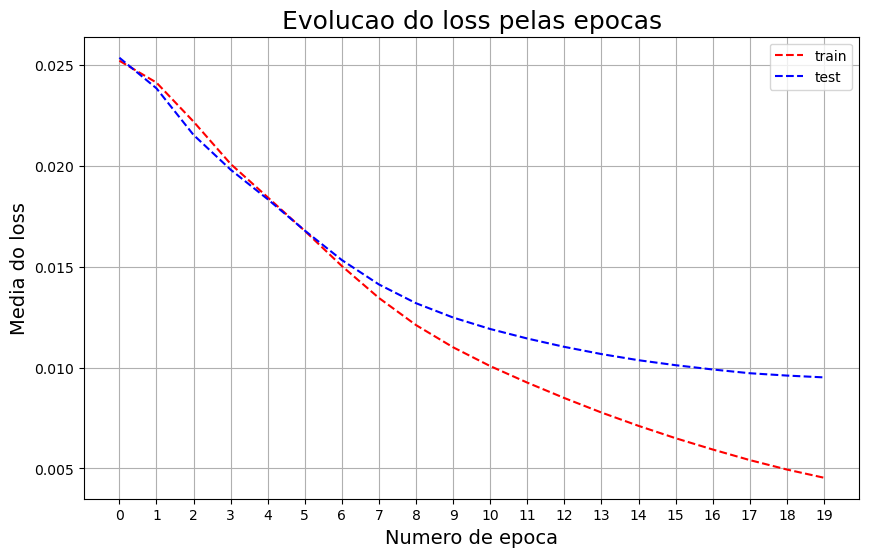

In [38]:
# plot the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Evolucao do loss pelas epocas", fontsize=18)
plt.ylabel("Media do loss", fontsize=14)
plt.xlabel("Numero de epoca", fontsize=14)
plt.plot(train_losses, '--r')
plt.plot(test_losses, '--b')
plt.xticks([i for i in range(epochs)])
# plt.xlim([i + 1 for i in range(epochs)])
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
def preprocess_text(text, vectorizer):
    # Aplicar a mesma transformação utilizada no conjunto de treinamento
    text_transformed = vectorizer.transform([text])
    tensor = torch.Tensor(text_transformed.toarray())
    return tensor

In [ ]:
import joblib

In [ ]:
# Salvar o vetorizador
joblib.dump(vectorizer, f"./modelos/vetorizador_{len_entrada}.pkl")

# Salvar o modelo
torch.save(model.state_dict(), f"./modelos/modelo_{len_entrada}.pth")

In [35]:
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

len_entrada = 25659
len_saida = 5

le = LabelEncoder()
le.fit_transform(
    ["ARISTOTLE",
    "NIETZSCHE",
    "PLATO",
    "SCHOPENHAUER",
    "THOMAS AQUINAS"]
)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len_entrada, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, len_saida)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Carregar o vetorizador
loaded_vectorizer = joblib.load(f"./modelos/vetorizador_{len_entrada}.pkl")

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# Carregar o modelo
loaded_model = NeuralNetwork().to(device)
loaded_model.load_state_dict(torch.load(f"./modelos/modelo_{len_entrada}.pth"))
loaded_model.eval()


input_text = input("Digite uma frase: ")
# Utilizar o modelo carregado para fazer previsões
preprocessed_text = preprocess_text(input_text, loaded_vectorizer)
preprocessed_text = preprocessed_text.to(device)

with torch.no_grad():
    loaded_model.eval()
    prediction = loaded_model(preprocessed_text)
    predicted_class = prediction.argmax().item()

predicted_class_label = le.inverse_transform([predicted_class])[0]

print("Frase:", input_text)
print("Classe prevista:", predicted_class_label)

Frase: Wagner
Classe prevista: SCHOPENHAUER


In [ ]:
# df = pd.read_csv('./dados/sentencas_autores.csv')
# df.sentences = df.sentences.astype(str)

In [ ]:
# import torchtext

In [ ]:
# from torchtext.data.utils import get_tokenizer
# from nltk import word_tokenize


# tokenizer = get_tokenizer('basic_english')
# # tokenizer = word_tokenize('english')

# def split_tokens(row):
#     sentences = row['sentences']
#     row['tokens'] =  tokenizer(sentences)
#     return row

# df = df.apply(split_tokens, axis=1)

In [ ]:
# df.head()

In [ ]:
# from collections import Counter

# counter = Counter()

# for tokens in df.tokens:
#     counter.update(tokens)

# counter.most_common(100)

In [ ]:
# import string
# from nltk.corpus import stopwords

# stopwords = stopwords.words('english')
# punctuations = set(string.punctuation)

# def remove_stopwords_and_punctuations(row):
#     tokens = row['tokens']
#     filtered_tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token not in punctuations and not token.isdigit()]
#     row['tokens'] = filtered_tokens
#     return row

# df = df.apply(remove_stopwords_and_punctuations, axis=1)

In [ ]:
# from collections import Counter

# counter = Counter()

# for tokens in df.tokens:
#     counter.update(tokens)

# len(counter)

In [ ]:
# df.to_csv('./dados/filosofos_tokens.csv', index=False)

In [ ]:
# import torchtext
# vocab_custom = torchtext.vocab.build_vocab_from_iterator(df['tokens'],
#                                                          min_freq=3,
#                                                          specials=['<unk>'])

In [ ]:
# vocab_custom.set_default_index(vocab_custom['<unk>'])

In [ ]:
# len(vocab_custom)

In [ ]:
# def vocab(tokens):
#   result = []
#   for token in tokens:
#     result.append(vocab_custom[token])

#   return result


# vocab(df.tokens[0][:10])

In [ ]:
# def token2id(row):
#     row['tokens_id'] = vocab(row['tokens'])
#     return row

# df = df.apply(token2id, axis=1)

In [ ]:
# autores_unique = df.autor.unique()

# df['label'] = df['autor'].apply(lambda x: list(autores_unique).index(x))

# df.head()

In [ ]:
# df.tail()

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader

In [ ]:
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# class FILODataset(Dataset):
#     def __init__(self, dataset):
#         self.dataset = dataset
#         self.data = dataset['tokens_id']

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#       return torch.tensor(self.data.iloc[idx]), torch.tensor(self.dataset.iloc[idx, -1])

# dataset_filo = FILODataset(train_df)
# dataloader = DataLoader(FILODataset(train_df), shuffle=True, batch_size=256)

# print(dataset_filo[0])
# print(dataset_filo[1])

In [ ]:
# from torch import nn

# EMBED_LEN = 50
# HIDDEN_DIM = 16
# N_LAYERS = 1
# DROPOUT_RATE = 0.2
# L2_PENALTY = 1e-4

# N_outputs = N_outputs = len(autores_unique)


# class CategoryClassifier(nn.Module):
#   def __init__(self):
#     super(CategoryClassifier, self).__init__()

#     self.embedding_layer = nn.Embedding(num_embeddings=len(vocab_custom),
#                                         embedding_dim=EMBED_LEN)
#     self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS)
#     self.dropout_lstm = nn.Dropout(p=DROPOUT_RATE)
#     self.linear = nn.Linear(HIDDEN_DIM, N_outputs)
#     self.dropout_linear = nn.Dropout(p=DROPOUT_RATE)

#   def forward(self, input):

#         embeddings = self.embedding_layer(input)
#         lstm_out, (hn, cn) = self.lstm(embeddings)
#         lstm_out = self.dropout_lstm(lstm_out)
#         linear_out = self.linear(hn[0])
#         linear_out = self.dropout_linear(linear_out)
        
#         return linear_out

In [ ]:
# from torch import nn

# EMBED_LEN = 16
# HIDDEN_DIM = 8
# N_LAYERS = 1
# L2_PENALTY = 1e-4

# N_outputs = len(autores_unique)

# class TextClassifier(nn.Module):
#     def __init__(self):
#         super(TextClassifier, self).__init__()

#         self.embedding_layer = nn.Embedding(num_embeddings=len(vocab_custom),
#                                             embedding_dim=EMBED_LEN)
#         self.rnn = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS)
#         self.linear = nn.Linear(HIDDEN_DIM, N_outputs)


#     def forward(self, input):

#         embeddings = self.embedding_layer(input)
        
#         output, final_hidden = self.rnn(embeddings)

#         return self.linear(final_hidden[0])

In [ ]:
# model = CategoryClassifier()

In [ ]:
# model(torch.tensor(train_df['tokens_id'].iloc[0]))

In [ ]:
# device = torch.device('cpu')
# model.to(device)

In [ ]:
# LR = 8e-3
# EPOCHS = 5

# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_PENALTY)

In [ ]:
# from tqdm.notebook import tqdm

# def train(dataloader):
#   train_loss = 0

#   for batch, (data, label) in enumerate(tqdm(dataloader)):

#       label_aux = [0 for i in range(N_outputs)]
#       label_aux[label] = 1
#       label_aux = torch.tensor(label_aux)

#       data, label = data.to(device), label_aux.to(device)
      

#       out = model(data[0])
#       loss = loss_fn(out.to(torch.float32), label_aux.to(torch.float32))

#       train_loss += loss.item()
      
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       if batch % 1000 == 0:
#           loss, current = loss.item(), batch * len(data)
#           print(f' loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]')
        
#   train_loss /= len(dataloader.dataset)  # média do loss
#   return train_loss

In [ ]:
# def test(dataloader):
#   size = len(dataloader.dataset)
#   test_loss, correct = 0, 0

#   with torch.no_grad():
#     for data, label in tqdm(dataloader):

#       label_aux = [0 for i in range(N_outputs)]
#       label_aux[label] = 1
#       label_aux = torch.tensor(label_aux)

#       data, label = data.to(device), label_aux.to(device)
#       out = model(data[0])

#       loss = loss_fn(out.to(torch.float32), label_aux.to(torch.float32))
#       test_loss += loss.item()

#       if torch.argmax(out).item() == torch.argmax(label).item():
#         correct += 1

#   test_loss /= size
#   correct /= size

#   print(f' test accuracy: {(100*correct):>0.1f}%, test loss: {test_loss:>8f} ')

#   return test_loss